In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from load import mnist
from copy import deepcopy

from theano.tensor.nnet import conv2d
from theano.tensor.signal.downsample import max_pool_2d

srng = RandomStreams()


def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(T.dot(X, w_h))
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))
    #h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

def model_drop(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(T.dot(X, w_h))
    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))
    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

def dropout(X, p_use=0.5):
    bi = srng.binomial(size=X.shape, p=p_use)
    noise_X = X*bi / p_use
    return noise_X


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## 2 Dropout

### Without dropout

In [3]:
trX, teX, trY, teY = mnist(onehot=True)

X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))


noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.8, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 1., 1.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

accuracy = []
for i in range(50): #you can adjust this if training takes too long
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    accuracy.append(np.mean(np.argmax(teY, axis=1) == predict(teX)))
    print accuracy[-1]


0.9446
0.9648
0.9735
0.9765
0.9779
0.9793
0.9758
0.9785
0.9786
0.9779
0.9825
0.9809
0.9807
0.9811
0.9821
0.9834
0.9803
0.981
0.9805
0.9813
0.9829
0.9835
0.9831
0.9834
0.9834
0.9834
0.9834
0.9834
0.9833
0.9833
0.9833
0.9833
0.9833
0.9833
0.9833
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832
0.9832


### With dropout:

In [ ]:
trX, teX, trY, teY = mnist(onehot=True)

X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))


noise_h, noise_h2, noise_py_x = model_drop(X, w_h, w_h2, w_o, 0.8, 0.5)
h, h2, py_x = model_drop(X, w_h, w_h2, w_o, 1., 1.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(50): #you can adjust this if training takes too long
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))



0.9398
0.9632
0.968
0.9711
0.9728
0.9745
0.9754
0.9736
0.9777

## 3 Parametric Relu

In [4]:
def PRelu(X, a):
    return X * (X > 0) + a*X * (X <= 0)

def model_a(X, w_h, a_h, w_h2, a_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = PRelu(T.dot(X, w_h), a_h)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(T.dot(h, w_h2), a_h2)
    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [5]:
trX, teX, trY, teY = mnist(onehot=True)

X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

a_h = init_weights((625,))
a_h2 = init_weights((625,))

save_wh = w_h.get_value()
save_ah = a_h.get_value()



noise_h, noise_h2, noise_py_x = model_a(X, w_h, a_h, w_h2, a_h2, w_o, 0.8, 0.5)
h, h2, py_x = model_a(X, w_h, a_h, w_h2, a_h2, w_o, 1., 1.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o, a_h, a_h2]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10): #you can adjust this if training takes too long
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print 'Iteration: ' i, 'Test Error: ' np.mean(np.argmax(teY, axis=1) == predict(teX))

0.9443
0.9637
0.9712
0.9728
0.9755
0.9778
0.9787
0.9815
0.9811
0.9821


## Convolutional Layers

In [12]:
conv2d?

In [3]:
trX, teX, trY, teY = mnist(onehot=True)

trX = trX.reshape ( -1 , 1 , 28 , 28) # trainings data
teX = teX.reshape ( -1 , 1 , 28 , 28) # test data

X = T.dtensor4()
Y = T.fmatrix()

### Initialize Weights
# Convolutional Layer 1
f1 = 32
pic_in1 = 1
k_x1 = 5
k_y1 = 5
w_conv1 = init_weights (( f1 , pic_in1 , k_x1 , k_y1 ))

# Convolutional Layer 2
f2 = 64
pic_in2 = 32
k_x2 = 5
k_y2 = 5
w_conv2 = init_weights (( f2 , pic_in2 , k_x2 , k_y2 ))

# Convolutional Layer 3
f3 = 128
pic_in3 = 64
k_x3 = 2
k_y3 = 2
w_conv3 = init_weights (( f3 , pic_in3 , k_x3 , k_y3 ))

number_of_output_pixel = 128*5*5
w_h = init_weights((number_of_output_pixel, 625))
w_o = init_weights((625, 10))

### Generate layers
# Convolution Layer 1
conv_layer1 = conv2d(X, w_conv1, border_mode='full')
subsampling_layer1 = max_pool_2d(conv_layer1, (2, 2), ignore_border=True)

# Convolution Layer 2
conv_layer2 = conv2d(subsampling_layer1, w_conv2)
subsampling_layer2 = max_pool_2d(conv_layer2, (2, 2), ignore_border=True)

# Convolution Layer 3
conv_layer3 = conv2d(subsampling_layer2, w_conv3)
#subsampling_layer3 = max_pool_2d(conv_layer3, (2, 2))  # ergibt ungerade anzahl da 5/2
conv_layer3_flattened = T.flatten(conv_layer3, outdim=2)

# Hidden Layer with dropout
conv_layer3_flattened = dropout(conv_layer3_flattened, p_use=0.6)
h = rectify(T.dot(conv_layer3_flattened, w_h))

# Output Layer
h = dropout(h, p_use=0.6)
py_x = T.nnet.softmax(T.dot(h, w_o))
y_x = T.argmax(py_x, axis=1)


cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_conv1, w_conv2, w_conv3, w_h, w_o]
updates = RMSprop(cost, params, lr=0.001)

train   = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(2):
    print 'Iteration {}'.format(i)
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))




Iteration 0
0.96
Iteration 1
0.9772


array([[-0.05433033, -0.02998288,  0.01142353,  0.02933507,  0.00144583],
       [-0.02571649,  0.00255158,  0.02833814,  0.03395322, -0.00805263],
       [-0.07703578, -0.05529545,  0.06401781,  0.06904632, -0.00598017],
       [-0.02869132,  0.01415443,  0.02854917,  0.00027654, -0.0361004 ],
       [ 0.02152119,  0.00280247,  0.01834208, -0.02490788, -0.05560225]])

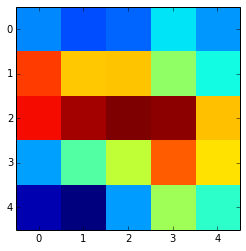

In [16]:
wc1 = w_conv1.get_value()

plt.imshow(wc1[2,0,:,:], interpolation='nearest')

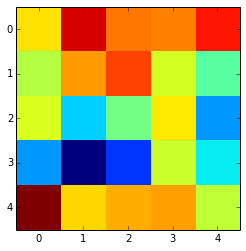

In [23]:
wc2 = w_conv2.get_value()

plt.imshow(wc2[5,0,:,:], interpolation='nearest')

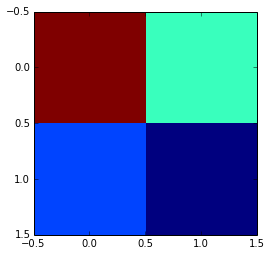

In [21]:
wc3 = w_conv3.get_value()

plt.imshow(wc3[3,0,:,:], interpolation='nearest')

<matplotlib.colorbar.Colorbar instance at 0x7f724214f878>

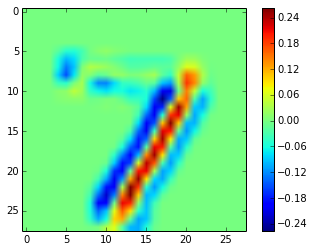

In [51]:
import scipy as sp

#sp.signal.convolve2d()

img7 = teX[0,0,:,:]

filtered7_1 = sp.signal.convolve2d(img7, wc1[0,0,:,:], mode='same')

plt.imshow(filtered7_1)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f7242671290>

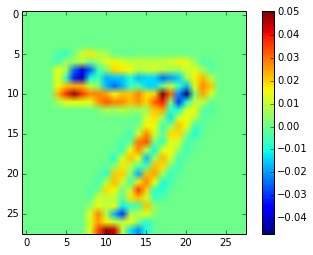

In [47]:
filtered7_2 = sp.signal.convolve2d(img7, wc2[4,0,:,:], mode='same')

plt.imshow(filtered7_2)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f724227c710>

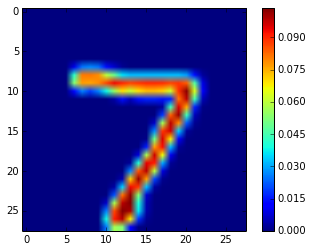

In [50]:
filtered7_3 = sp.signal.convolve2d(img7, wc3[2,0,:,:], mode='same')

plt.imshow(filtered7_3)
plt.colorbar()